# Ανάπτυξη Sarimax Μοντέλου για την πρόβλεψη του πληθωρισμού του επόμενου εξαμήνου.

In [1]:
# Απαραίτητες Βιβλιοθήκες
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
# Ανάγνωση Δεδομένων
greece_inflation = pd.read_csv('Inflation and Parameters.csv')
greece_inflation.head()

,Date,Cpi,Food Price Index,Energy Price Index,Hicp,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
0,2001-01-01,0.001806,0.016060,0.111474,0.003837,0.109312,0.000000,0.000000,0.315560,0.000000
1,2001-02-01,0.000000,0.011688,0.097947,0.000000,0.110324,0.005330,0.006099,0.328415,0.017084
2,2001-03-01,0.036626,0.008565,0.077760,0.042722,0.110324,0.010660,0.012198,0.341270,0.034167
3,2001-04-01,0.054424,0.003301,0.082858,0.063443,0.118421,0.015991,0.018297,0.354126,0.051251
4,2001-05-01,0.062677,0.009190,0.087208,0.072909,0.117409,0.029163,0.025907,0.352209,0.054301


In [3]:
# Έλεγχος για nan τιμές
print("Nan Values:\n" + str(greece_inflation.isna().sum()))

Nan Values:
Date                  0
Cpi                   0
Food Price Index      0
Energy Price Index    0
Hicp                  0
Unemployment Rate     0
Gdp                   0
Rent Price            0
House Prices          0
Lci                   0
dtype: int64


In [4]:
# Κάνουμε shift τα δεδομένα έξι μήνες πίσω, και τα αποθηκεύουμε στην στήλη Actual.
# Αυτό γίνεται για να δημιουργηθούν sequences για την εκπαίδευση του μοντέλου.
steps=-6
greece_inflation_for_prediction= greece_inflation.copy()
greece_inflation_for_prediction["Actual"]= greece_inflation_for_prediction["Cpi"].shift(steps)
greece_inflation_for_prediction.head()

,Date,Cpi,Food Price Index,Energy Price Index,Hicp,Unemployment Rate,Gdp,Rent Price,House Prices,Lci,Actual
0,2001-01-01,0.001806,0.016060,0.111474,0.003837,0.109312,0.000000,0.000000,0.315560,0.000000,0.026825
1,2001-02-01,0.000000,0.011688,0.097947,0.000000,0.110324,0.005330,0.006099,0.328415,0.017084,0.027341
2,2001-03-01,0.036626,0.008565,0.077760,0.042722,0.110324,0.010660,0.012198,0.341270,0.034167,0.063451
3,2001-04-01,0.054424,0.003301,0.082858,0.063443,0.118421,0.015991,0.018297,0.354126,0.051251,0.069641
4,2001-05-01,0.062677,0.009190,0.087208,0.072909,0.117409,0.029163,0.025907,0.352209,0.054301,0.071705


In [5]:
# αφαίρεση nan τιμών
greece_inflation_for_prediction = greece_inflation_for_prediction.dropna()

In [6]:
# ορισμός της στήλης Date ως Index
greece_inflation_for_prediction.index = greece_inflation_for_prediction["Date"]

In [7]:
greece_inflation_for_prediction.head()

,Date,Cpi,Food Price Index,Energy Price Index,Hicp,Unemployment Rate,Gdp,Rent Price,House Prices,Lci,Actual
Date,,,,,,,,,,,
2001-01-01,2001-01-01,0.001806,0.016060,0.111474,0.003837,0.109312,0.000000,0.000000,0.315560,0.000000,0.026825
2001-02-01,2001-02-01,0.000000,0.011688,0.097947,0.000000,0.110324,0.005330,0.006099,0.328415,0.017084,0.027341
2001-03-01,2001-03-01,0.036626,0.008565,0.077760,0.042722,0.110324,0.010660,0.012198,0.341270,0.034167,0.063451
2001-04-01,2001-04-01,0.054424,0.003301,0.082858,0.063443,0.118421,0.015991,0.018297,0.354126,0.051251,0.069641
2001-05-01,2001-05-01,0.062677,0.009190,0.087208,0.072909,0.117409,0.029163,0.025907,0.352209,0.054301,0.071705


Text(0.5, 1.0, 'Cpi Index')

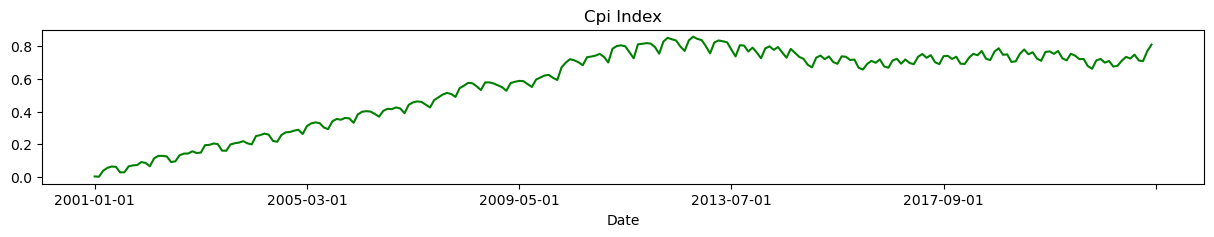

In [8]:
greece_inflation_for_prediction["Cpi"].plot(color="green", figsize=(15,2))
plt.title("Cpi Index")

In [9]:
# επιλογή των στηλών που έχουν άμεση επίδραση στον πληθωρισμό, και τις actual τιμές του Cpi
cols = ['Unemployment Rate', 'Actual']
X = greece_inflation_for_prediction[cols]
X.head()

,Unemployment Rate,Actual
Date,,
2001-01-01,0.109312,0.026825
2001-02-01,0.110324,0.027341
2001-03-01,0.110324,0.063451
2001-04-01,0.118421,0.069641
2001-05-01,0.117409,0.071705


In [10]:
# επιλογή των τιμών του Cpi που είναι 6 μήνες μπροστά, τις οποίες ορίζουμε ως target value
cols = ['Cpi']
y = greece_inflation_for_prediction[cols]
y.head()

,Cpi
Date,
2001-01-01,0.001806
2001-02-01,0.000000
2001-03-01,0.036626
2001-04-01,0.054424
2001-05-01,0.062677


In [11]:
# split δεδομένων σε train και test
train_size=int(len(greece_inflation) * 0.7)
test_size = int(len(greece_inflation)) - train_size

train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [12]:
train_X.head()

,Unemployment Rate,Actual
Date,,
2001-01-01,0.109312,0.026825
2001-02-01,0.110324,0.027341
2001-03-01,0.110324,0.063451
2001-04-01,0.118421,0.069641
2001-05-01,0.117409,0.071705


In [13]:
train_y.head()

,Cpi
Date,
2001-01-01,0.001806
2001-02-01,0.000000
2001-03-01,0.036626
2001-04-01,0.054424
2001-05-01,0.062677


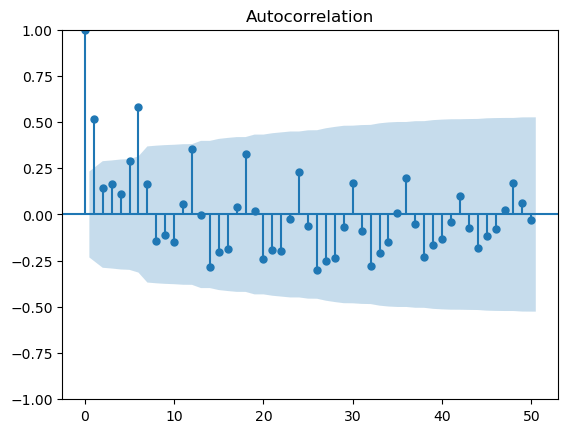

In [14]:
# σχεδιασμός γραφήματος των autocorrelation τιμών
fig=sm.tsa.graphics.plot_acf(test_y, lags=50)
plt.show()

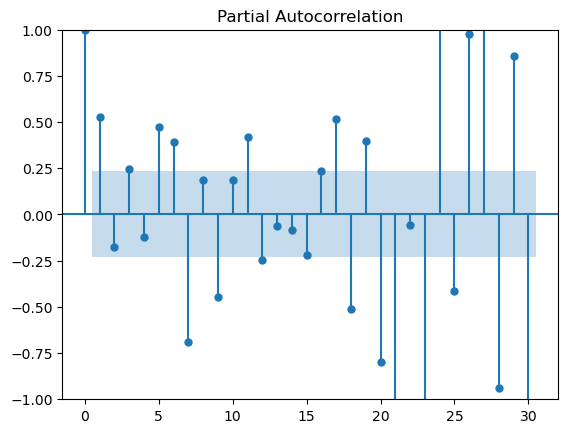

In [15]:
# σχεδιασμός γραφήματος των partial autocorrelation τιμών
fig=sm.tsa.graphics.plot_pacf(test_y, lags=30)
plt.show()

In [16]:
# εφαρμογή του SARIMAX μοντέλου στα train και test δεδομένα
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, train_X, order=(0,0,0),enforce_invertibility=False, enforce_stationarity=False)

C:\Users\chris\anaconda4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chris\anaconda4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
# fit μοντέλου
results= model.fit()

In [18]:
# δημιουργία προβλέψεων
predictions= results.predict(start = train_size, end=train_size+test_size+(steps)-1,exog=test_X)

In [22]:
forecast_1= results.forecast(steps=test_size+steps, exog=test_X)

In [23]:
act= pd.DataFrame(greece_inflation_for_prediction.iloc[train_size:, 1])

In [24]:
act.head()

,Cpi
Date,
2015-12-01,0.718855
2016-01-01,0.668558
2016-02-01,0.657983
2016-03-01,0.691772
2016-04-01,0.710859


In [25]:
# δημιουργία dataframe που περιέχει τα actual και predicted δεδομένα
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Cpi']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [26]:
predictions

,Pred,Actual
Date,,
2015-12-01,0.726712,0.718855
2016-01-01,0.689431,0.668558
2016-02-01,0.680501,0.657983
2016-03-01,0.720819,0.691772
2016-04-01,0.727608,0.710859
...,...,...
2021-06-01,0.794187,0.749291
2021-07-01,0.784888,0.713180
2021-08-01,0.809311,0.709827


<AxesSubplot:xlabel='Date'>

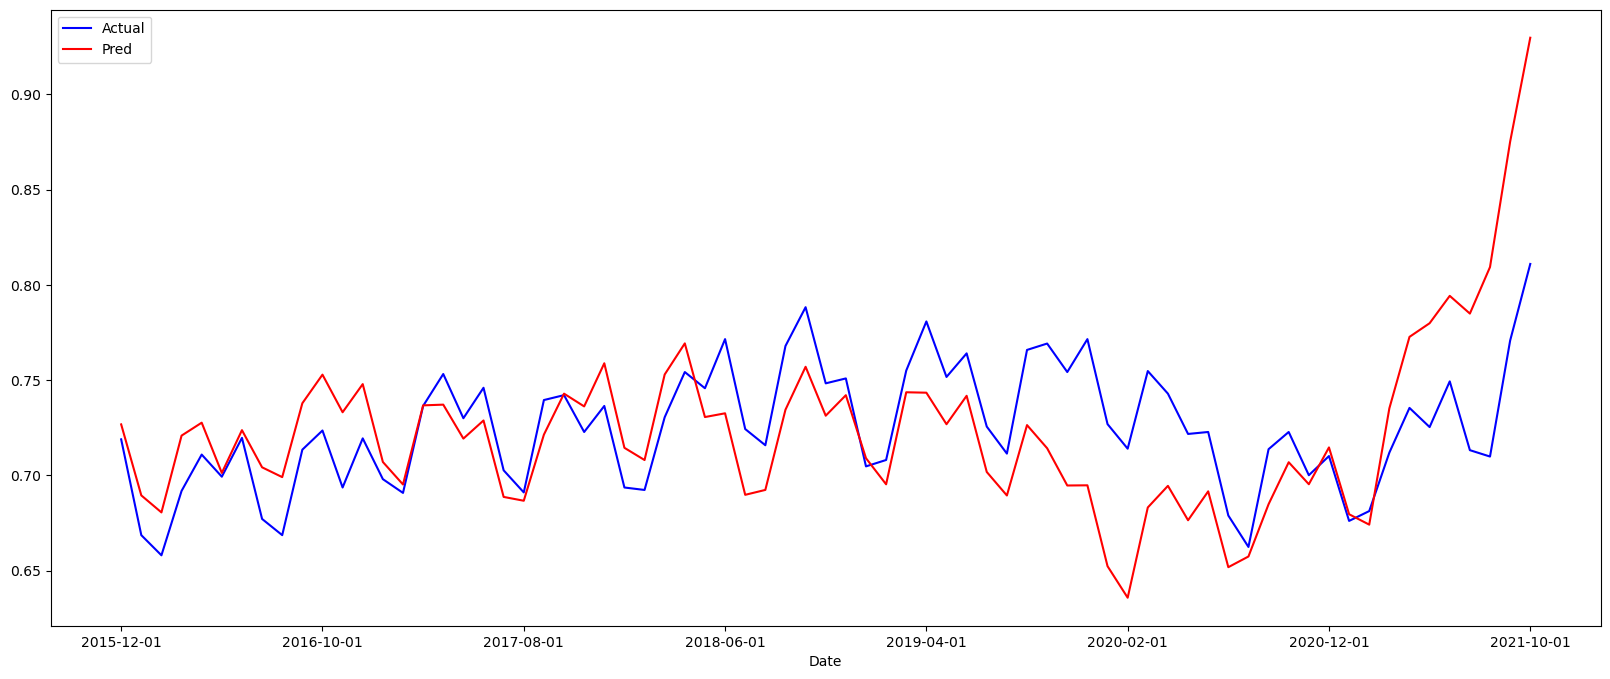

In [27]:
# plot των actual και predicted τιμών
predictions["Actual"].plot(figsize=(20,8), legend=True, color="blue")
predictions["Pred"].plot(legend=True, color="red", figsize=(20,8))

In [28]:
# Ίδιο plot με διαφορετικό τρόπο
forecast = pd.DataFrame(forecast_1)
forecast.reset_index(drop=True, inplace=True)
forecast.index=test_X.index
forecast["Actual"] = greece_inflation_for_prediction.iloc[train_size:, 1]
forecast.rename(columns={'predicted_mean':"Forecast"}, inplace=True)

In [29]:
forecast

,Forecast,Actual
Date,,
2015-12-01,0.726712,0.718855
2016-01-01,0.689431,0.668558
2016-02-01,0.680501,0.657983
2016-03-01,0.720819,0.691772
2016-04-01,0.727608,0.710859
...,...,...
2021-06-01,0.794187,0.749291
2021-07-01,0.784888,0.713180
2021-08-01,0.809311,0.709827


<AxesSubplot:xlabel='Date'>

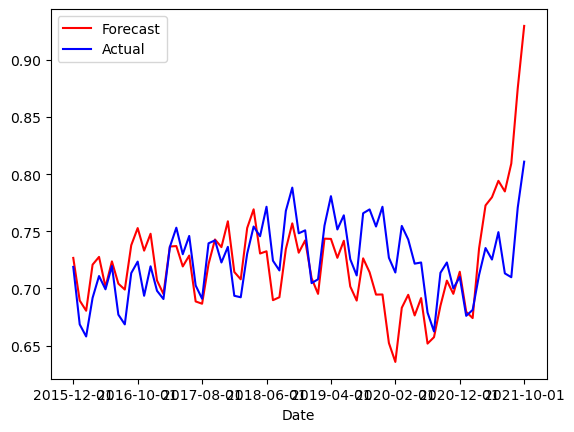

In [30]:
forecast["Forecast"].plot(legend=True, color='red')
forecast["Actual"].plot(legend=True, color='blue')

In [31]:
# Υπολιγισμός MAE για την αξιολόγιση της πρόβλεψης
from statsmodels.tools.eval_measures import meanabs
error = meanabs(predictions["Pred"], predictions["Actual"])
error

0.029291554342029947